In [125]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pyclustering.cluster.cure import cure
from pyclustering.utils import timedcall

**Pulizia del dataset che interessa questo clustering**

In [126]:
def inconsistence_cleaning(df: pd.DataFrame) -> pd.DataFrame:
    """ 
    Rimuove le righe che presentano inconsistenze.
    """
    
    mask1 = df.incident_characteristics1 == 'Shot - Dead (murder, accidental, suicide)'
    mask2 = df.n_killed == 0
    final_mask = mask1 & mask2
    df = df[~final_mask]

    mask1 = df.incident_characteristics1 == 'Shot - Wounded/Injured'
    mask2 = df.n_injured == 0
    final_mask = mask1 & mask2
    df = df[~final_mask]
    
    return df

def get_prepared_dataset() -> pd.DataFrame:
    df = pd.read_csv('../../data/cleaned_data.csv').reset_index(names='id')
    df['date'] = pd.to_datetime(df['date'])
    df = df[df.state == 'Illinois']
    
    df = df[df.n_participants > 0]
    df = inconsistence_cleaning(df)
    return df

**Creazione delle features per il clustering**

In [127]:
#Selezione delle colonne utili per il clustering
selected_columns = ['latitude', 'longitude', 'n_participants_child', 'n_participants_teen', 'n_participants_adult', 'avg_age_participants',
                    'n_males', 'n_females', 'n_killed', 'n_arrested', 'n_unharmed', 'n_injured', 'n_participants', 'povertyPercentage']
df = get_prepared_dataset()[selected_columns]

df['n_participants_child_ratio'] = df['n_participants_child'] / df['n_participants']
df['n_participants_teen_ratio'] = df['n_participants_teen'] / df['n_participants']
df['n_participants_adult_ratio'] = df['n_participants_adult'] / df['n_participants']

df['n_males_ratio'] = df['n_males']/df['n_participants']
df['n_females_ratio'] = df['n_females']/df['n_participants']

df['n_arrested_ratio'] = df['n_arrested']/df['n_participants']
df['n_unharmed_ratio'] = df['n_unharmed']/df['n_participants']
df['n_injured_ratio'] = df['n_injured']/df['n_participants']
df['n_killed_ratio'] = df['n_killed']/df['n_participants']

df['poverty_ratio'] = df['povertyPercentage']/100

df['incident_severity'] = (df['n_killed_ratio'] + df['n_injured_ratio'])/df['n_participants']


In [128]:
selected_columns = pd.Index(['n_participants_child_ratio', 'n_participants_teen_ratio', 
                             'n_participants_adult_ratio', 'n_males_ratio', 'n_females_ratio', 
                             'n_arrested_ratio', 'n_unharmed_ratio', 'n_injured_ratio', 
                             'n_killed_ratio', 'poverty_ratio', 'incident_severity', 'n_participants'])

df = df[selected_columns].dropna()
df.reset_index(inplace=True)

**Standardization del dataframe scelto**

In [129]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(df.values)

## Cure Clustering

**Scetla del miglior valore di k con elbow method***

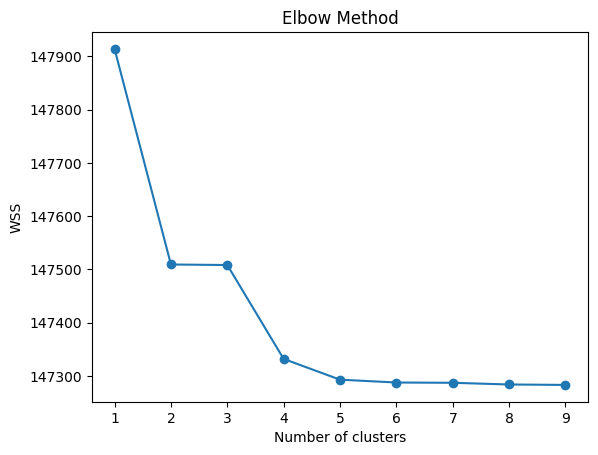

In [130]:
# Calcola WSS per diversi valori di k
wss_values = []
clusters_list = []
for k in range(1, 10):
    cure_instance = cure(X, k)
    _, cure_processing_time = timedcall(cure_instance.process)
    clusters = cure_instance.get_clusters()
    clusters_list.append(clusters)
    wss = sum(np.sum((X[cluster] - np.mean(X[cluster]))**2) for cluster in clusters)
    wss_values.append(wss)

# Crea il grafico Elbow
plt.plot(range(1, 10), wss_values, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WSS')
plt.show()


Dall'elbow method si può osservare che il miglior valore è k=2

In [136]:
clusters = clusters_list[2]

**Analisi features dopo il clustering***

In [137]:
def add_cluster_label(df, clusters):
    cluster_labels = np.empty(len(df), dtype=int)
    for cluster_id, cluster_indices in enumerate(clusters):
        cluster_labels[cluster_indices] = cluster_id
    df['cluster'] = cluster_labels
    
    df = df[['index', 'cluster']]
    final_df = get_prepared_dataset()
    final_df = final_df.merge(df, left_on='id', right_on='index').drop(columns=['index'])
    return final_df

In [138]:
final_df = add_cluster_label(df, clusters)

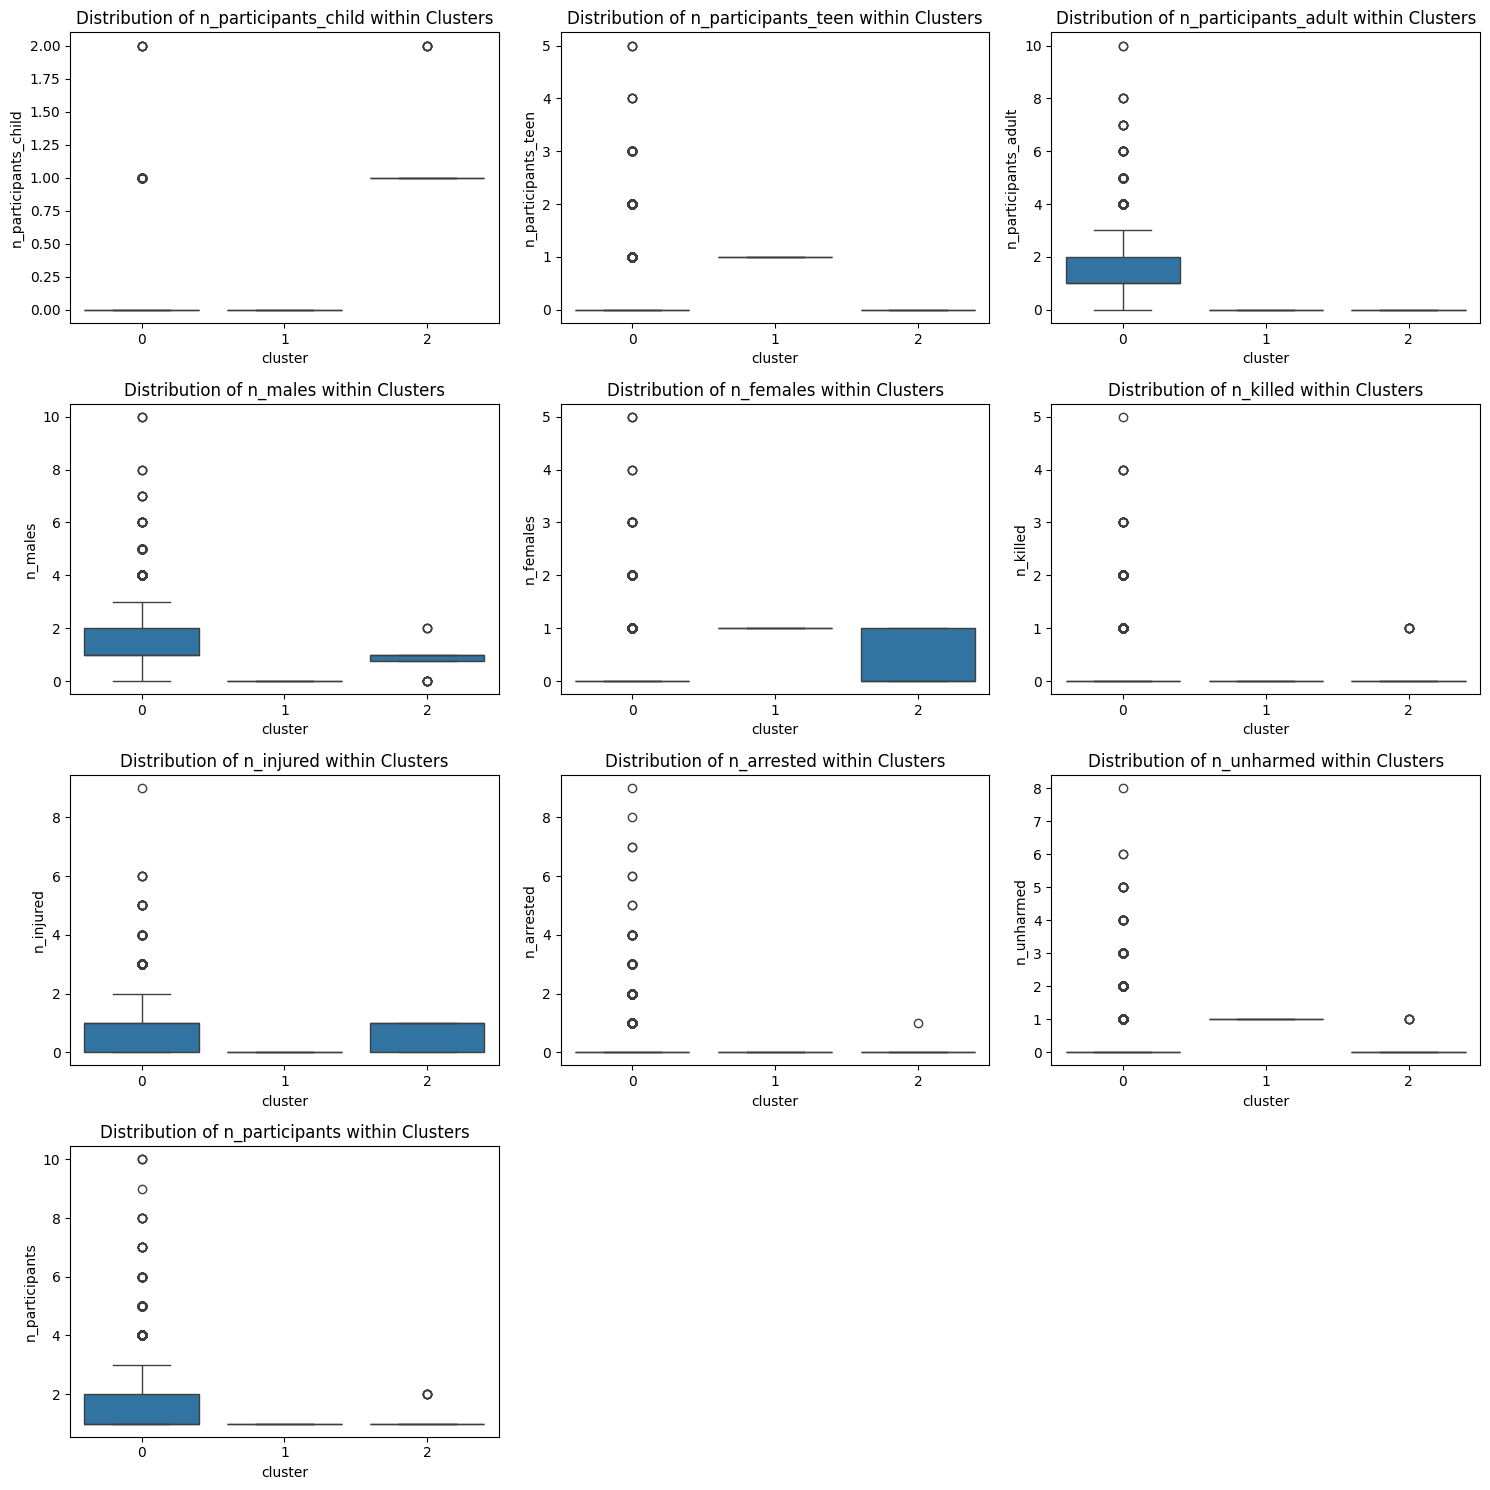

In [139]:
attribute = ['n_participants_child', 'n_participants_teen',
            'n_participants_adult', 'n_males', 'n_females', 'n_killed', 'n_injured',
            'n_arrested', 'n_unharmed', 'n_participants', 'cluster']

data = final_df[attribute]

# Calcola il numero di righe e colonne necessarie per la griglia di grafici
n = len(data.columns) - 1
ncols = int(n**0.5)
nrows = ncols if ncols**2 == n else ncols + 1

# Crea una figura e degli assi
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15))

# Disegna un grafico per ogni variabile
for ax, variable in zip(axs.flatten(), data.columns[:-1]):
    sns.boxplot(x='cluster', y=variable, data=data, ax=ax)
    ax.set_title(f'Distribution of {variable} within Clusters')

# Rimuovi gli assi vuoti
for ax in axs.flatten()[n:]:
    ax.remove()

plt.tight_layout()
plt.show()


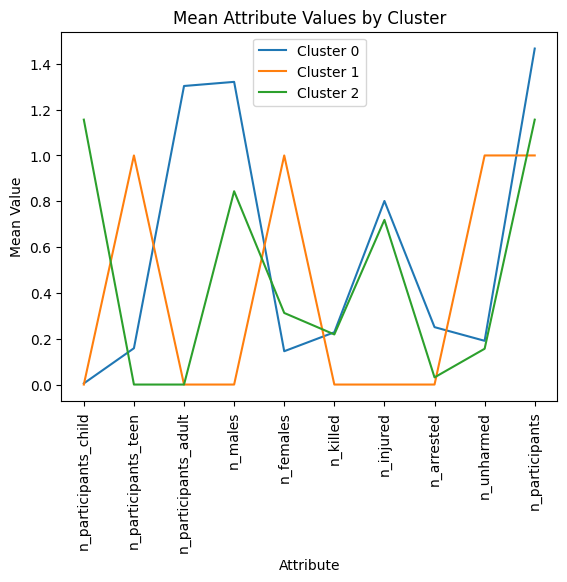

In [140]:
# Calcola la media di ciascun attributo per cluster
means = final_df[attribute].groupby('cluster').mean()

# Crea un grafico a linee per ciascun cluster
for cluster in means.index:
    plt.plot(means.columns, means.loc[cluster], label=f'Cluster {cluster}')

plt.xlabel('Attribute')
plt.ylabel('Mean Value')
plt.title('Mean Attribute Values by Cluster')
plt.legend()
plt.xticks(rotation=90)  # Ruota le etichette dell'asse x per una migliore leggibilità
plt.show()
